<a href="https://colab.research.google.com/github/JorgeMoranBornemann/BScThesis/blob/main/Notebook_BScThesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Permafrost thaw data analysis**

The purpose of this notebook is to run through the steps, and explain, how the data analysis was performed.

It will be divided into several sections.
1. Importing libraries and data + preliminary data analysis
2. Multiple linear regression SOC, Soil moisture, thaw depth.
3. Graphical analysis of thaw depth progression over the season.
4. How are the cummulative thawing degree days at different depths influenced by soil moisture and SOC?
5. How is soil moisture influenced by the irrigation treatments?



# Importing libraries and datasets

In [1]:
#Importing required libraries
import pandas as pd
import numpy as np
import math
import statistics
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import datetime as dt
import itertools
import seaborn as sns
import statsmodels.api as sm

In [2]:
# importing the datasets and converting them to pandas dataframes

# Datasets saved in a public github repo: https://github.com/JorgeMoranBornemann/BScThesis
URL_soilmoisture = 'https://raw.githubusercontent.com/JorgeMoranBornemann/BScThesis/main/Datasets/all_soilmoisture.csv'
URL_ibuttons_overview = 'https://raw.githubusercontent.com/JorgeMoranBornemann/BScThesis/main/Datasets/ibuttons_overview.csv'
URL_SoilTParsed = 'https://raw.githubusercontent.com/JorgeMoranBornemann/BScThesis/main/Datasets/SoilTParsed.csv'
URL_all_thawdepth = 'https://raw.githubusercontent.com/JorgeMoranBornemann/BScThesis/main/Datasets/all_thawdepth.csv'
URL_irrigationlog = 'https://raw.githubusercontent.com/JorgeMoranBornemann/BScThesis/main/Datasets/irrigationlog.csv'
URL_plotcoordinates = 'https://raw.githubusercontent.com/JorgeMoranBornemann/BScThesis/main/Datasets/plot_coordinates.csv'
URL_BD_OM = 'https://raw.githubusercontent.com/JorgeMoranBornemann/BScThesis/main/Datasets/PreprocessedBD_OC.csv'

# loading the CSV data as pandas df
df_sm = pd.read_csv(URL_soilmoisture)
df_ib = pd.read_csv(URL_ibuttons_overview)
df_sT = pd.read_csv(URL_SoilTParsed)
df_tD = pd.read_csv(URL_all_thawdepth)
df_ir = pd.read_csv(URL_irrigationlog)
df_pl = pd.read_csv(URL_plotcoordinates)
df_OM = pd.read_csv(URL_BD_OM)

# Pre-analysis of lab data

The following codeblocks clean the BD-OM dataset by converting the data to numeric and removing NaN values. A scatter plot is then made to see the variability in OM and BD per location.

<ipython-input-3-b592dce91a27>:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(subset['BD'], subset['SOM'], label=f'location {loc}', c=palette[loc - 1], marker=marker, s=25)


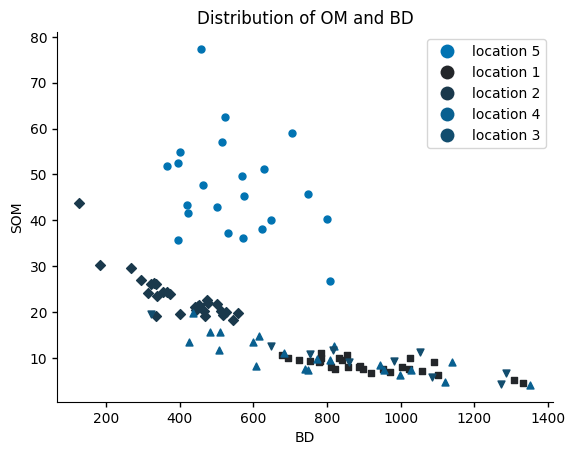

In [3]:

# Assuming df_OM is your DataFrame
df_OM['BD'] = pd.to_numeric(df_OM['BD'], errors='coerce')
df_OM['SOM'] = pd.to_numeric(df_OM['SOM'], errors='coerce')

# Drop rows with NaN values in the specified columns
df_OM_cleaned = df_OM.dropna(subset=['BD', 'SOM'])

# Set a colorblind-friendly palette
palette = sns.color_palette('colorblind', n_colors=len(df_OM_cleaned['location'].unique()))
palette = sns.dark_palette(palette[0], reverse=False, n_colors=len(df_OM_cleaned['location'].unique()))

# Create a scatter plot with different colors and markers for each location
fig, ax = plt.subplots()
for loc, marker in zip(df_OM_cleaned['location'].unique(), ['o', 's', 'D', '^', 'v']):
    subset = df_OM_cleaned[df_OM_cleaned['location'] == loc]
    ax.scatter(subset['BD'], subset['SOM'], label=f'location {loc}', c=palette[loc - 1], marker=marker, s=25)

# Create custom legend entries
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'location {loc}', markerfacecolor=palette[loc - 1], markersize=10, markeredgewidth=0)
                   for loc in df_OM_cleaned['location'].unique()]

# Add labels and a custom legend
ax.set_xlabel('BD')
ax.set_ylabel('SOM')
ax.set_title('Distribution of OM and BD')
ax.legend(handles=legend_elements)

# Add transparent axis lines inside the graph
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

# Add small lines to denote the decimals on the x and y axes
ax.xaxis.set_tick_params(width=1)
ax.yaxis.set_tick_params(width=1)

# Show the plot
plt.show()

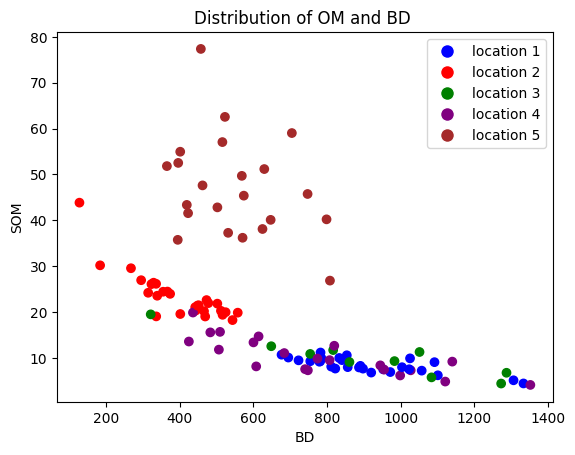

In [4]:
# Create a scatter plot with different colors for each location

# Changing the values in the csv to numeric so matplotlib can work with it
df_OM['BD'] = pd.to_numeric(df_OM['BD'], errors='coerce')
df_OM['SOM'] = pd.to_numeric(df_OM['SOM'], errors='coerce')
# Drop rows with NaN values in the specified columns
df_OM_cleaned = df_OM.dropna(subset=['BD', 'SOM'])

# Set a colorblind-friendly palette
palette = sns.color_palette('colorblind', n_colors=len(df_OM_cleaned['location'].unique()))

colors = df_OM['location'].map({1: 'blue', 2: 'red', 3: 'green', 4: 'purple', 5:'brown'})
plt.scatter(df_OM['BD'], df_OM['SOM'], c=colors, )

# Create custom legend entries
legend_elements = [Line2D([0], [0], marker='o', color='w', label='location 1', markerfacecolor='blue', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='location 2', markerfacecolor='red', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='location 3', markerfacecolor='green', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='location 4', markerfacecolor='purple', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='location 5', markerfacecolor='brown', markersize=10) ]

# Add labels and a custom legend
plt.xlabel('BD')
plt.ylabel('SOM')
plt.title('Distribution of OM and BD ')
plt.legend(handles=legend_elements)

# Add transparent axis lines inside the graph
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

# Add small lines to denote the decimals on the x and y axes
ax.xaxis.set_tick_params(width=0.5)
ax.yaxis.set_tick_params(width=0.5)

# Show the plot
plt.show()

In [5]:
# some pointless statistics for the graph above

x = df_OM_cleaned['BD']
y = df_OM_cleaned['SOM']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict(x)

print_model = model.summary()
print(print_model)


                            OLS Regression Results                            
Dep. Variable:                    SOM   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     55.92
Date:                Sat, 02 Dec 2023   Prob (F-statistic):           2.20e-11
Time:                        10:01:32   Log-Likelihood:                -432.14
No. Observations:                 109   AIC:                             868.3
Df Residuals:                     107   BIC:                             873.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.3352      3.279     13.216      0.0

# Multiple linear regression

The following section aims to stablish the relationship between soil organic carbon, soil moisture, and thaw depth. This will be done via a multiple linear regression of the form: $TD \sim \beta_0 + \beta_1 SOC + \beta_2SM$.

Where TD is the dependent variable thaw depth [m], SOC is the first explanatory variable, soil organic carbon [%] and SM is the second explanatory variable, soil moisture [%].

The analysis is structured as follows.

1. Isolate the desired date in the TD and SM dataframes.
2. Reformat the SM dataframe to have the sampling points as columns.
3. Join the OM, SM and TD dataframes.
4. Perform the multiple linear regression
5. Plot the points + regression line.


In [31]:
#The following code filters the data from df_sm and df_tD to locations 1 and 2 and the selected year.
year = 2023

df_sm_filtered = df_sm[(df_sm['location'].isin([1, 2])) & (df_sm['year'] == year)]
df_tD_filtered = df_tD[(df_tD['location'].isin([1, 2])) & (df_tD['year'] == year)]

In [32]:
# this cell queries the df_sm and df_tD (filtered) datasets to find suitable DOYs. A Suitable DOY must have data for all treatments
# C, I, ES and LS on both the df_sm and df_tD datasets.

#Empty list with suitable DOYs
validDOY = []

#List containing the treatments. A suitable DOY must have all treatments present on both datasets
Treatments = ['C', 'I', 'ES' , 'LS']

#iterates for every DOY, from 1 to 365
for DOY in range(1, 366):
  #a temporary dataframe is created for the current DOY being investigated, on both dataframes
  dfA_adj = df_sm_filtered[df_sm_filtered['DOY'] == DOY]
  dfB_adj = df_tD_filtered[df_tD_filtered['DOY'] == DOY]

  # a and b are true if all treatments in that DOY are present
  a = all(value in dfA_adj['treatment'].values for value in Treatments)
  b = all(value in dfB_adj['treatment'].values for value in Treatments)

  # if both datasets contain all treatments for a particular DOY, that DOY is appended to the empty list and advanced once.
  if a == True and b == True:
    validDOY.append(DOY)
    DOY += 1

  # if the condition is not met, the DOY is advanced but not recorded.
  else:
    DOY += 1

# Print the list of DOYs. Only these DOYs are usable for the analysis.
print(validDOY)

[175, 181, 191, 197]


In [33]:
# A valid DOY is chosen
Chosen_DOY = 197

# This re-filters the dataframes to select the DOY.
df_sm_filtered = df_sm[(df_sm['location'].isin([1, 2])) & (df_sm['year'] == year) & (df_sm['DOY'] == Chosen_DOY)]
df_tD_filtered = df_tD[(df_tD['location'].isin([1, 2])) & (df_tD['year'] == year) & (df_tD['DOY'] == Chosen_DOY)]

#drops unnecesary columns from TD dataset
df_tD_filtered = df_tD_filtered.drop(['date', 'year', 'DOY', 'CumLS2022', 'CumES2023', 'CumLS2023', 'Note'], axis=1)
#sorts the TD dataframe
df_tD_filtered = df_tD_filtered.sort_values(by=['location', 'plot', 'point']).reset_index(drop=True)

#reformats the SM dataset by turning it "vertical" (Columns A, C, E, G, I become rows)
df_sm_formatted = pd.melt(df_sm_filtered, id_vars=['location', 'treatment', 'pair', 'plot'], value_vars = ['A', 'C', 'E', 'G', 'I'], var_name='point', value_name='SM')
df_sm_formatted = df_sm_formatted.sort_values(by=['location', 'plot', 'point']).reset_index(drop=True)

#merges the two dataframes so soil moisture and thaw depth are together
df_TD_SM = pd.merge(df_tD_filtered, df_sm_formatted, on=['location', 'treatment', 'pair', 'plot', 'point'])

# cleaning the df_OM dataset to only include locations 1 and 2 and remove unnecesary columns and rows.
df_OM_filtered = df_OM[df_OM['location'].isin([1,2])]
df_OM_filtered = df_OM_filtered.dropna(subset=['BD', 'SOM'])
df_OM_filtered = df_OM_filtered[df_OM_filtered['sample_replicate'] <= 1]
df_OM_filtered = df_OM_filtered.drop(['MossLayer', 'AdditionalComments', 'sample_replicate'], axis=1)

#combines the thaw depth and soil mositure dataset with the soil organic matter and bulk density dataset
df_TD_SM_OM = pd.merge(df_TD_SM, df_OM_filtered, on=['location', 'treatment', 'pair', 'plot'])

In [35]:
df_TD_SM_OM

,location,treatment,pair,plot,point,TD,SM,BD,SOM
0,1,C,1,1C1,A,81,21.4,779.4,9.1521
1,1,C,1,1C1,C,79,20.5,779.4,9.1521
2,1,C,1,1C1,E,78,13,779.4,9.1521
3,1,C,1,1C1,G,77,19.1,779.4,9.1521
4,1,C,1,1C1,I,76,23.2,779.4,9.1521
...,...,...,...,...,...,...,...,...,...
275,2,LS,7,2LS7,A,46,37.8,469.2,19.0206
276,2,LS,7,2LS7,C,44,36.1,469.2,19.0206
277,2,LS,7,2LS7,E,52,38.6,469.2,19.0206
278,2,LS,7,2LS7,G,48,44,469.2,19.0206


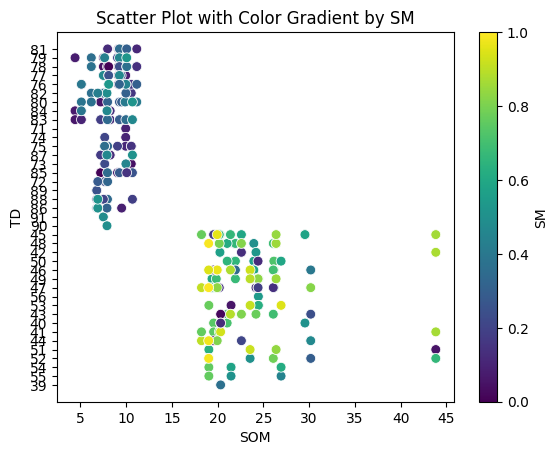

In [51]:
# Create a scatter plot with color gradient by SM
scatter_plot = sns.scatterplot(x='SOM', y='TD', hue='SM', palette='viridis', size='SM', sizes=(50, 50), data=df_TD_SM_OM)

# Remove the default legend
scatter_plot.get_legend().remove()

# Add a Colorbar
cbar = plt.colorbar(scatter_plot.collections[0], ax=scatter_plot, orientation='vertical')
cbar.set_label('SM')

# Increase the step between displayed numbers on the y-axis
#plt.yticks(range(40, 81, 20))

# Add labels and a title
plt.xlabel('SOM')
plt.ylabel('TD')
plt.title('Scatter Plot with Color Gradient by SM')

# Show the plot
plt.show()

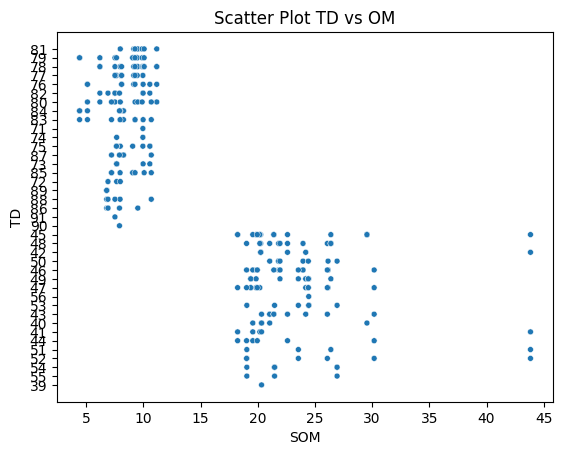

In [55]:
# Create a scatter plot with color gradient by SM
scatter_plot = sns.scatterplot(x='SOM', y='TD', size = 40, data=df_TD_SM_OM)

# Remove the default legend
scatter_plot.get_legend().remove()

# Add a Colorbar
#cbar = plt.colorbar(scatter_plot.collections[0], ax=scatter_plot, orientation='vertical')
#cbar.set_label('SM')

# Increase the step between displayed numbers on the y-axis
#plt.yticks(range(40, 81, 20))

# Add labels and a title
plt.xlabel('SOM')
plt.ylabel('TD')
plt.title('Scatter Plot TD vs OM')

# Show the plot
plt.show()

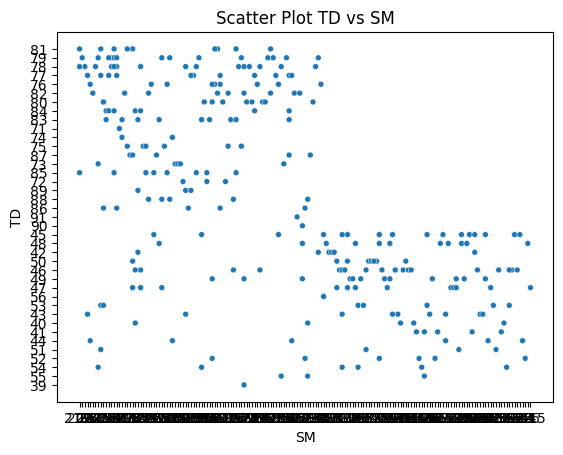

In [56]:
# Create a scatter plot with color gradient by SM
scatter_plot = sns.scatterplot(x='SM', y='TD', size = 40, data=df_TD_SM_OM)

# Remove the default legend
scatter_plot.get_legend().remove()

# Add a Colorbar
#cbar = plt.colorbar(scatter_plot.collections[0], ax=scatter_plot, orientation='vertical')
#cbar.set_label('SM')

# Increase the step between displayed numbers on the y-axis
#plt.yticks(range(40, 81, 20))

# Add labels and a title
plt.xlabel('SM')
plt.ylabel('TD')
plt.title('Scatter Plot TD vs SM')

# Show the plot
plt.show()

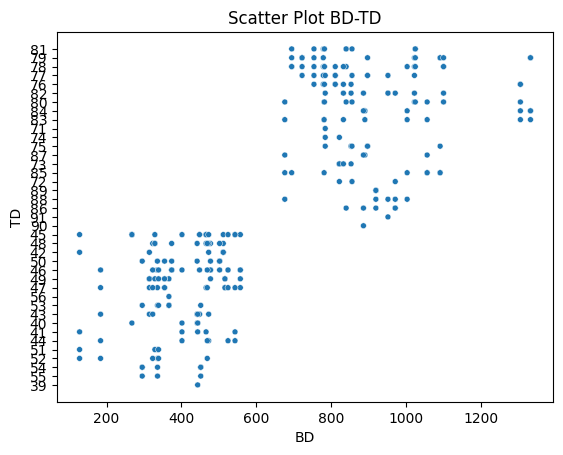

In [57]:
# Create a scatter plot with color gradient by SM
scatter_plot = sns.scatterplot(x='BD', y='TD', size = 40, data=df_TD_SM_OM)

# Remove the default legend
scatter_plot.get_legend().remove()

# Add a Colorbar
#cbar = plt.colorbar(scatter_plot.collections[0], ax=scatter_plot, orientation='vertical')
#cbar.set_label('SM')

# Increase the step between displayed numbers on the y-axis
#plt.yticks(range(40, 81, 20))

# Add labels and a title
plt.xlabel('BD')
plt.ylabel('TD')
plt.title('Scatter Plot BD-TD')

# Show the plot
plt.show()

# Thawing degree days analysis

**4. TTD-preprocessing**

In the following section, we extract the number of thawing degree days (TTD) in consecutive 10-day periods from the SoilTParsed.csv dataset. We also extract the thaw depth at the end of this 10-day period. After this, we will substract each subsequent thaw depth to get the thaw depth difference after each 10-day period, ΔTD. This data will then be stored in a separate dataset.

In [ ]:
for col in df_sT.columns:
  print(col)

Unnamed: 0
Time
Temp
Plot
Depth
Location
Day
Month
Year
Hour
Min
TimeParsed
Treatment


In [ ]:
#adds a DOY column to the dataframe
df_sT['Date-conv'] = pd.to_datetime(df_sT[['Year', 'Month', 'Day']])
df_sT['DOY'] = df_sT['Date-conv'].dt.dayofyear


df_sT.loc[['DOY']]








KeyError: ignored

In [ ]:
for col in df_sT.columns:
  print(col)

#df_sT_Day = df_sT.loc[:, ("Day", "Temp")]
#df_sT_Day.head

Unnamed: 0
Time
Temp
Plot
Depth
Location
Day
Month
Year
Hour
Min
TimeParsed
Treatment
Date-conv
DOY


In [ ]:
df_sT.head

<bound method NDFrame.head of         Unnamed: 0               Time  Temp  Plot Depth  Location  Day  Month  \
0                1  21/07/22 21:31:00   9.0   1C1    20         1   21      7   
1                2  22/07/22 01:46:00   8.0   1C1    20         1   22      7   
2                3  22/07/22 06:01:00   8.0   1C1    20         1   22      7   
3                4  22/07/22 10:16:00   7.5   1C1    20         1   22      7   
4                5  22/07/22 14:31:00   7.5   1C1    20         1   22      7   
...            ...                ...   ...   ...   ...       ...  ...    ...   
110452      110453   31/07/2023 20:46   8.0  5LS3     5         5   31      7   
110453      110454    01/08/2023 1:01   7.5  5LS3     5         5    1      8   
110454      110455    01/08/2023 5:16   7.0  5LS3     5         5    1      8   
110455      110456    01/08/2023 9:31   7.5  5LS3     5         5    1      8   
110456      110457   01/08/2023 13:46   8.0  5LS3     5         5    1      8  